# Quadratic limb darkening

#### Code to express the quadratic limb darkening specific intensity map as a sum of spherical harmonics

We begin by importing some stuff and defining our functions. Note that these are all defined in `A.ipynb`.

In [31]:
import numpy as np
from IPython.display import display, Math
import sympy
from sympy import *
from sympy.functions.special.tensor_functions import KroneckerDelta

# Initialize the session
init_session(quiet=True)

# I am using the dev version of sympy
print("Using sympy version", sympy.__version__)

# Define our symbols
x, y, z, mu, nu, l, m, j, k, p, q, n, u1, u2 = symbols('x y z mu nu l m j k p q n u1 u2')
y0 = Symbol('Y_0,0')
y1 = Symbol('Y_1,-1')
y2 = Symbol('Y_1,0')
y3 = Symbol('Y_1,1')
y4 = Symbol('Y_2,-2')
y5 = Symbol('Y_2,-1')
y6 = Symbol('Y_2,0')
y7 = Symbol('Y_2,1')
y8 = Symbol('Y_2,2')

# Definitions from `bp.ipynb`
def ptilde(n, x, y):
    """Return the n^th term in the polynomial basis."""
    l = floor(sqrt(n))
    m = n - l * l - l
    mu = l - m
    nu = l + m
    if (nu % 2 == 0):
        i = mu // 2
        j = nu // 2
        k = 0
    else:
        i = (mu - 1) // 2
        j = (nu - 1) // 2
        k = 1
    return x ** i * y ** j * sqrt(1 - x ** 2 - y ** 2) ** k

# Definitions from `ylmxyz.ipynb`
def A(l, m):
    """A spherical harmonic normalization constant."""
    return sqrt((2 - KroneckerDelta(m, 0)) * (2 * l + 1) * factorial(l - m) / (4 * pi * factorial(l + m)))

def B(l, m, j, k):
    """Another spherical harmonic normalization constant."""
    try: 
        ratio = factorial((l + m + k - 1) / 2) / factorial((-l + m + k - 1) / 2)
    except ValueError:
        ratio = 0
    return 2 ** l * factorial(m) / (factorial(j) * factorial(k) * factorial(m - j) * factorial(l - m - k)) * ratio

def C(p, q, k):
    """Return the binomial theorem coefficient `C`."""
    return factorial(k / 2) / (factorial(q / 2) * factorial((k - p) / 2) * factorial((p - q) / 2))

def Y(l, m, x, y):
    """Return the spherical harmonic of degree `l` and order `m`."""
    res = 0
    z = sqrt(1 - x ** 2 - y ** 2)
    if (m >= 0):
        for j in range(0, m + 1, 2):
            for k in range(0, l - m + 1, 2):
                for p in range(0, k + 1, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p) // 2) * A(l, m) * B(l, m, j, k) * C(p, q, k) * x ** (m - j + p - q) * y ** (j + q)
            for k in range(1, l - m + 1, 2):
                for p in range(0, k, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p) // 2) * A(l, m) * B(l, m, j, k) * C(p, q, k - 1) * x ** (m - j + p - q) * y ** (j + q) * z          
    else:
        for j in range(1, abs(m) + 1, 2):
            for k in range(0, l - abs(m) + 1, 2):
                for p in range(0, k + 1, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p - 1) // 2) * A(l, abs(m)) * B(l, abs(m), j, k) * C(p, q, k) * x ** (abs(m) - j + p - q) * y ** (j + q)
            for k in range(1, l - abs(m) + 1, 2):
                for p in range(0, k, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p - 1) // 2) * A(l, abs(m)) * B(l, abs(m), j, k) * C(p, q, k - 1) * x ** (abs(m) - j + p - q) * y ** (j + q) * z

    return res

def Coefficient(expression, term):
    """Return the coefficient multiplying `term` in `expression`."""
    # Get the coefficient
    coeff = expression.coeff(term)
    # Set any non-constants in this coefficient to zero. If the coefficient
    # is not a constant, this is not the term we are interested in!
    coeff = coeff.subs(sqrt(1 - x ** 2 - y ** 2), 0).subs(x, 0).subs(y, 0)
    return coeff

def p_Y(l, m, lmax):
    """Return the polynomial basis representation of the spherical harmonic `Y_{lm}`."""
    ylm = Y(l, m, x, y)
    res = [ylm.subs(sqrt(1 - x ** 2 - y ** 2), 0).subs(x, 0).subs(y, 0)]
    for n in range(1, (lmax + 1) ** 2):
        res.append(Coefficient(ylm, ptilde(n, x, y)))
    return res

def A1(lmax):
    """Return the change of basis matrix A1. The columns of this matrix are given by `p_Y`."""
    res = zeros((lmax + 1) ** 2, (lmax + 1) ** 2)
    n = 0
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            res[n] = p_Y(l, m, lmax)
            n += 1
    return res


Using sympy version 1.1.2.dev


The specific intensity for a quadratically limb-darkened source is

\begin{align}
\frac{I(\mu)}{I(1)} &= 1 - u_1 (1 - \mu) - u_2 (1 - \mu)^2 \\
                    &= (1 - u_1 - u_2) + (u_1 + 2 u_2) \mu - u_2 \mu^2
\end{align}

Noting that $\mu = \cos\theta = z$ and that $z^2 = 1 - x^2 - y^2$, we may write

\begin{align}
\frac{I(x, y)}{I(1)} = (1 - u_1 - 2 u_2) + (u1 + 2 u_2) z + (u_2) x^2 + (u_2) y^2
\end{align}

This can be expressed in the polynomial basis as the vector

In [60]:
pvec = Matrix([1 - u1 - 2 * u2, 0, u1 + 2 * u2, 0, u2, 0, 0, 0, u2])
pvec.T

We can easily transform this into the spherical harmonic basis via the (inverse of the) change of basis matrix $\mathbf{A_1}$:

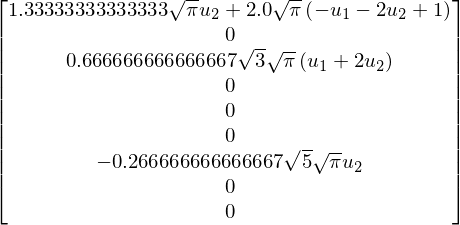

In [62]:
yvec = A1(2).inv() * pvec
yvec

Recalling that the basis of spherical harmonics is

In [52]:
ybasis = Matrix([y0, y1, y2, y3, y4, y5, y6, y7, y8])
ybasis.T

we can dot our vector in to get the expression for the specific intensity in spherical harmonics:

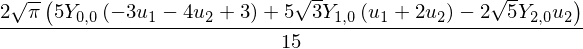

In [63]:
simplify(yvec.dot(ybasis), rational=True)

■